In [33]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Function to load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)



In [34]:
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data (standardizing to mean 0 and variance 1)
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Combine y_train and y_test for consistent label encoding
all_labels = np.concatenate((y_train, y_test))
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)  # Fit on the combined labels

# Encode the labels
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# One-hot encode the labels
y_train_onehot = to_categorical(y_train_encoded)
y_test_onehot = to_categorical(y_test_encoded)

# Reshape the data to fit the model input requirements
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

# Now, you can proceed with building and training your model

In [73]:
X_train[1]

array([ 0.05902829,  0.59634187, -0.19382516, ..., -0.12590321,
        0.03864603,  0.10263741])

Accuracy: 84.08%


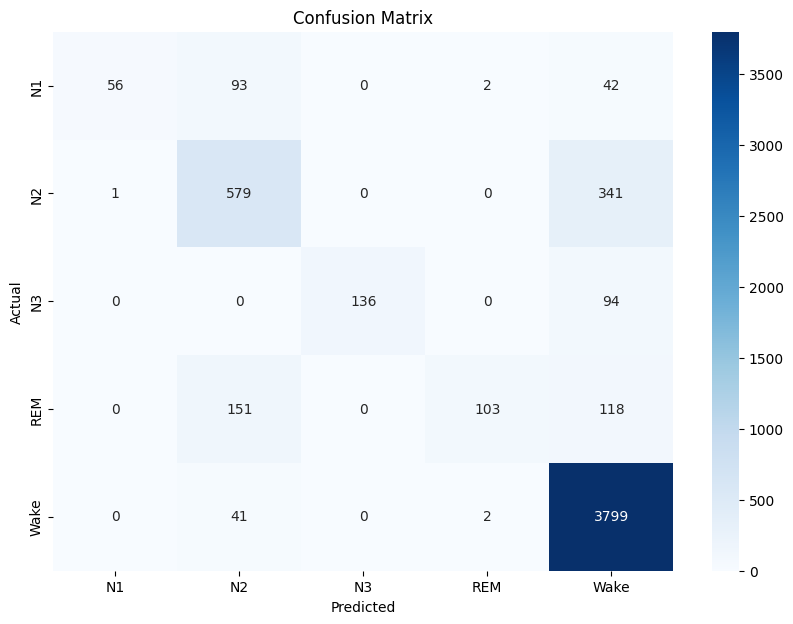

In [52]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Function to load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

# Remove instances of class 'e' and create a mask
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

# Apply the masks to X and y
X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test_modified = y_test_modified[test_mask]

# Combine the modified labels for encoding
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))

# Encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

# Encode the labels
y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

# Reshape the data to fit the model input requirements
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the input for Random Forest
X_test = X_test.reshape(X_test.shape[0], -1)

# Use SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Train Random Forest Classifier with the resampled data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [62]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Function to load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

 
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

 
X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test = y_test[test_mask]

 
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))

 
label_encoder = LabelEncoder()
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

# Encode the labels
y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

 
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the input for Neural Network
X_test = X_test.reshape(X_test.shape[0], -1)

 
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

 
model = keras.Sequential([
    layers.Input(shape=(X_train_resampled.shape[1],)),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(len(label_encoder.classes_), activation='softmax') 
])

 
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

 
history = model.fit(X_train_resampled, y_train_resampled, epochs=50, batch_size=32, validation_split=0.2)


Epoch 1/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6519 - loss: 0.9486 - val_accuracy: 0.0493 - val_loss: 3.2464
Epoch 2/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9324 - loss: 0.2394 - val_accuracy: 0.0493 - val_loss: 3.0420
Epoch 3/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9606 - loss: 0.1384 - val_accuracy: 0.0503 - val_loss: 2.0789
Epoch 4/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9686 - loss: 0.1086 - val_accuracy: 0.0517 - val_loss: 1.8766
Epoch 5/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9731 - loss: 0.0922 - val_accuracy: 0.0628 - val_loss: 1.7518
Epoch 6/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9766 - loss: 0.0755 - val_accuracy: 0.1068 - val_loss: 1.4797
Epoch 7/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9737 - loss: 0.0845 - val_accuracy: 0.1174 - val_loss: 1.5094
Epoch 8/50
259/259 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9799 - loss: 0.0593 - val_accu

174/174 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of y_test_encoded: (5558,), Shape of y_pred: (5558,)
Shape of X_test: (5558, 6000), Shape of y_test_modified: (5558,)
Accuracy: 83.29%


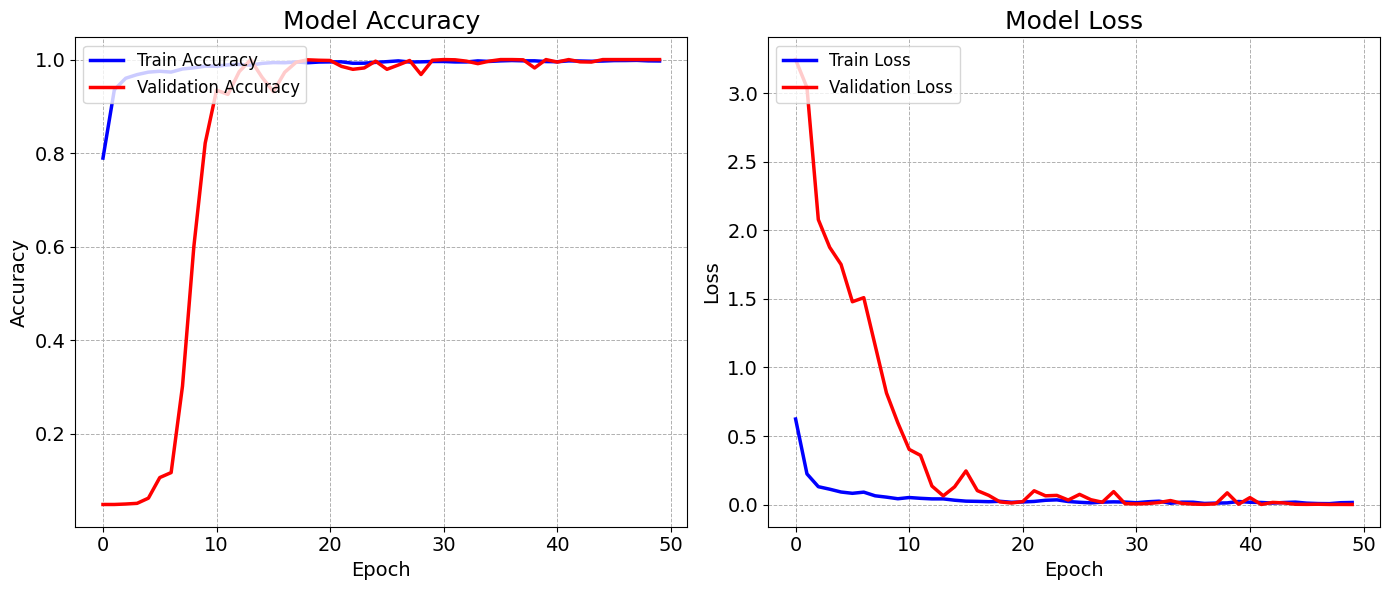

In [68]:
# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# Print shapes for debugging
print(f'Shape of y_test_encoded: {y_test_encoded.shape}, Shape of y_pred: {y_pred.shape}')
print(f'Shape of X_test: {X_test.shape}, Shape of y_test_modified: {y_test_modified.shape}')

# Calculate accuracy only if shapes match
if y_test_encoded.shape[0] == y_pred.shape[0]:
    accuracy = accuracy_score(y_test_encoded, y_pred)
    print(f'Accuracy: {accuracy * 100:.2f}%')
else:
    print("Mismatch in lengths: Cannot calculate accuracy.")

# Plot accuracy and loss over epochs
plt.figure(figsize=(14, 6))

# Line width for plots
line_width = 2.5

# Font sizes for titles, labels, legends
title_fontsize = 18
label_fontsize = 14
legend_fontsize = 12

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=line_width, color='b')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=line_width, color='r')
plt.title('Model Accuracy', fontsize=title_fontsize)
plt.ylabel('Accuracy', fontsize=label_fontsize)
plt.xlabel('Epoch', fontsize=label_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tick_params(axis='both', which='major', labelsize=label_fontsize)

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=line_width, color='b')
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=line_width, color='r')
plt.title('Model Loss', fontsize=title_fontsize)
plt.ylabel('Loss', fontsize=label_fontsize)
plt.xlabel('Epoch', fontsize=label_fontsize)
plt.legend(loc='upper left', fontsize=legend_fontsize)
plt.grid(True, linestyle='--', linewidth=0.7)
plt.tick_params(axis='both', which='major', labelsize=label_fontsize)

# Adjust layout
plt.tight_layout()
plt.show()


Accuracy: 84.08%


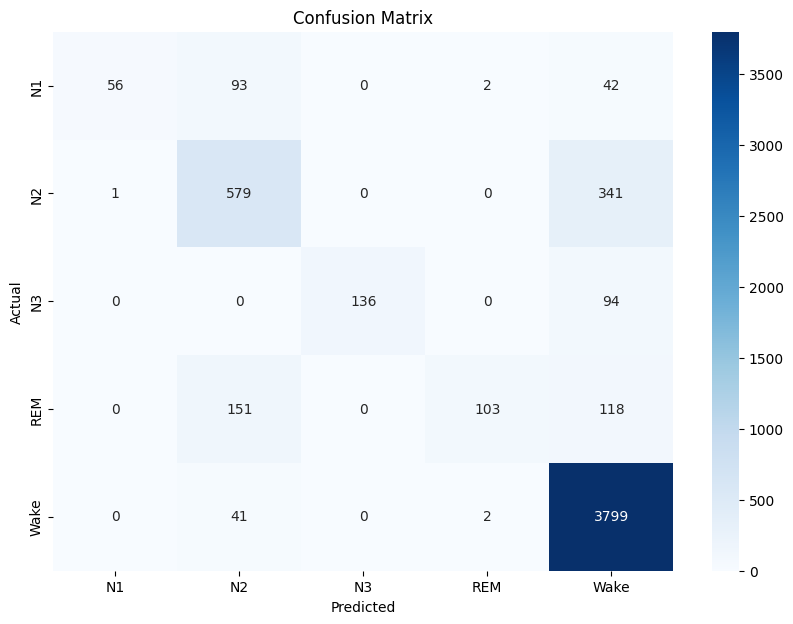


Classification Report:
               precision    recall  f1-score   support

          N1       0.98      0.29      0.45       193
          N2       0.67      0.63      0.65       921
          N3       1.00      0.59      0.74       230
         REM       0.96      0.28      0.43       372
        Wake       0.86      0.99      0.92      3842

    accuracy                           0.84      5558
   macro avg       0.90      0.56      0.64      5558
weighted avg       0.85      0.84      0.82      5558



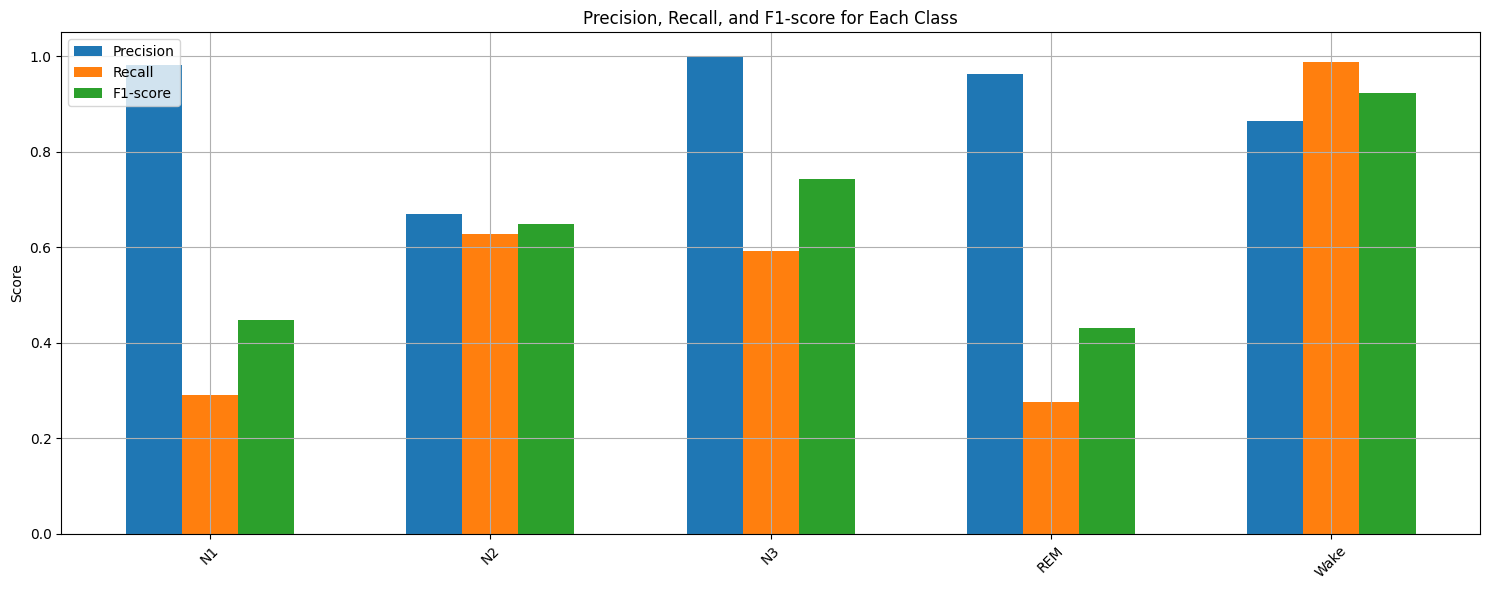

In [66]:
import os
import pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

# Function to load data from multiple .pkl files
def load_data_from_directory(directory):
    X_data, y_data = [], []
    for file in os.listdir(directory):
        if file.endswith(".pkl"):
            file_path = os.path.join(directory, file)
            with open(file_path, 'rb') as f:
                data = pickle.load(f)
                X_data.append(data['X'])
                y_data.append(data['y'])
    return np.array(X_data), np.array(y_data)

# Load data from train and test directories
train_dir = './preprocess/SLEEP_data/cassette_processed/train'
test_dir = './preprocess/SLEEP_data/cassette_processed/test'

X_train, y_train = load_data_from_directory(train_dir)
X_test, y_test = load_data_from_directory(test_dir)

# If the test set is empty, create it from a portion of the training data
if len(X_test) == 0 or len(y_test) == 0:
    print("Test set is empty. Splitting some data from the training set to use as the test set.")
    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Normalize the data
X_train = (X_train - np.mean(X_train)) / np.std(X_train)
X_test = (X_test - np.mean(X_test)) / np.std(X_test)

# Create a mapping for class modification
class_mapping = {
    'e': None,      # Class 'e' will be removed
    '1': 'N1',      # Map class '1' to 'N1'
    '2': 'N2',      # Map class '2' to 'N2'
    'W': 'Wake',    # Map class 'W' to 'Wake'
    'R': 'REM',     # Map class 'R' to 'REM'
    '3': 'N3',      # Merge class '3' into 'N3'
    '4': 'N3',      # Merge class '4' into 'N3'
}

# Modify the labels according to the mapping
def modify_labels(y):
    return np.array([class_mapping.get(label, label) for label in y])

y_train_modified = modify_labels(y_train)
y_test_modified = modify_labels(y_test)

# Remove instances of class 'e' and create a mask
train_mask = y_train_modified != None  # Mask for removing class 'e'
test_mask = y_test_modified != None     # Mask for removing class 'e'

# Apply the masks to X and y
X_train = X_train[train_mask]
y_train_modified = y_train_modified[train_mask]

X_test = X_test[test_mask]
y_test_modified = y_test_modified[test_mask]

# Combine the modified labels for encoding
all_labels_modified = np.concatenate((y_train_modified, y_test_modified))

# Encode the labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels_modified)  # Fit on the combined modified labels

# Encode the labels
y_train_encoded = label_encoder.transform(y_train_modified)
y_test_encoded = label_encoder.transform(y_test_modified)

# Reshape the data to fit the model input requirements
X_train = X_train.reshape(X_train.shape[0], -1)  # Flatten the input for Random Forest
X_test = X_test.reshape(X_test.shape[0], -1)

# Use SMOTE to balance the classes
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train_encoded)

# Train Random Forest Classifier with the resampled data
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_resampled, y_train_resampled)

# Make predictions
y_pred = rf_classifier.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, 
            yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_)
print("\nClassification Report:\n", report)

# Calculate Precision, Recall, F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test_encoded, y_pred, average=None)

# Bar chart for Precision, Recall, and F1-score
metrics = ['Precision', 'Recall', 'F1-score']
scores = [precision, recall, f1_score]

# Plotting multiple metrics for all classes
x = np.arange(len(label_encoder.classes_))
width = 0.2  # width of the bars

plt.figure(figsize=(15, 6))

# Plot Precision, Recall, F1-score bars
for i, (metric, score) in enumerate(zip(metrics, scores)):
    plt.bar(x + i * width, score, width, label=metric)

# Set the position and labels
plt.xticks(x + width, label_encoder.classes_, rotation=45)
plt.ylabel('Score')
plt.title('Precision, Recall, and F1-score for Each Class')
plt.legend(loc='upper left')
plt.grid()

plt.tight_layout()
plt.show()
